##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# Load and preprocess images

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/images"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to load and preprocess an image dataset in three ways:

- First, you will use high-level Keras preprocessing utilities (such as `tf.keras.utils.image_dataset_from_directory`) and layers (such as `tf.keras.layers.Rescaling`) to read a directory of images on disk.
- Next, you will write your own input pipeline from scratch [using tf.data](../../guide/data.ipynb).
- Finally, you will download a dataset from the large [catalog](https://www.tensorflow.org/datasets/catalog/overview) available in [TensorFlow Datasets](https://www.tensorflow.org/datasets).

## Setup

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)

2.16.1


### Download the flowers dataset

This tutorial uses a dataset of several thousand photos of flowers. The flowers dataset contains five sub-directories, one per class:

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

Note: all images are licensed CC-BY, creators are listed in the LICENSE.txt file.

In [3]:
data_dir = 'data_faces'

After downloading (218MB), you should now have a copy of the flower photos available. There are 3,670 total images:

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. You will use 80% of the images for training and 20% for validation.

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 441 files belonging to 2 classes.
Using 353 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 441 files belonging to 2 classes.
Using 88 files for validation.


You can find the class names in the `class_names` attribute on these datasets.

In [9]:
class_names = train_ds.class_names
print(class_names)

['happy', 'sad']


### Visualize the data

Here are the first nine images from the training dataset.

2024-05-21 19:51:34.540255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


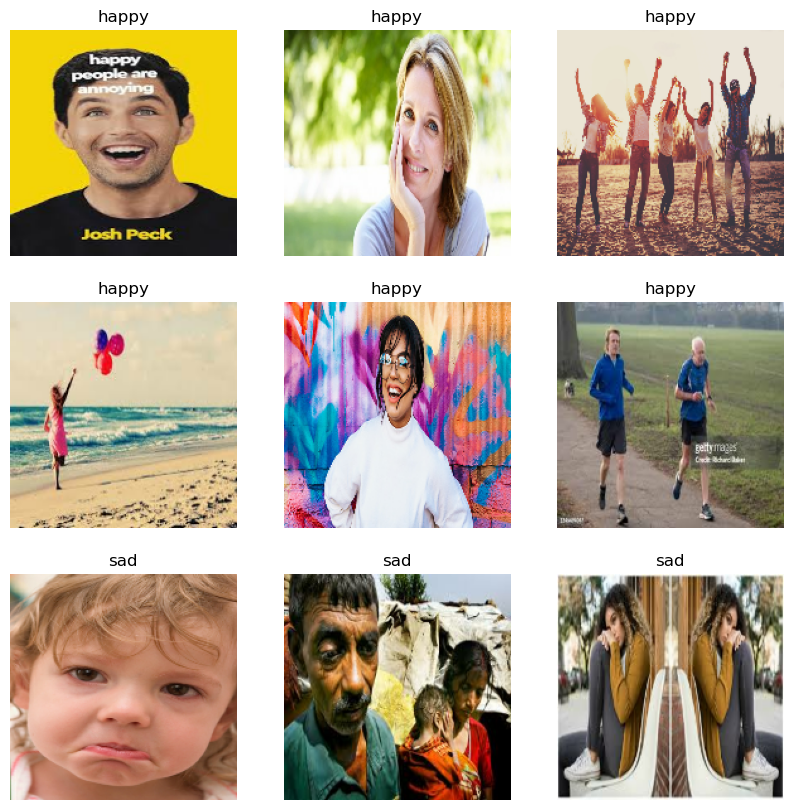

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You can train a model using these datasets by passing them to `model.fit` (shown later in this tutorial). If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on either of these tensors to convert them to a `numpy.ndarray`.

### Standardize the data


The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Or, you can include the layer inside your model definition to simplify deployment. You will use the second approach here.

Note: If you would like to scale pixel values to `[-1,1]` you can instead write `tf.keras.layers.Rescaling(1./127.5, offset=-1)`

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

### Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train a model

For completeness, you will show how to train a simple model using the datasets you have just prepared.

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned in any way—the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit the [Image classification](../images/classification.ipynb) tutorial.

In [15]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

Choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [16]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Note: You will only train for a few epochs so this tutorial runs quickly. 

In [17]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - accuracy: 0.6813 - loss: 0.8516 - val_accuracy: 0.4318 - val_loss: 0.8928
Epoch 2/3
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.5093 - loss: 0.7673 - val_accuracy: 0.6364 - val_loss: 0.6385
Epoch 3/3
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.6144 - loss: 0.6045 - val_accuracy: 0.7045 - val_loss: 0.5480


 4/92 [>.............................] - ETA: 15s - loss: 1.9631 - accuracy: 0.2422

 5/92 [>.............................] - ETA: 15s - loss: 1.9309 - accuracy: 0.2125

 6/92 [>.............................] - ETA: 15s - loss: 1.9187 - accuracy: 0.1979

 7/92 [=>............................] - ETA: 14s - loss: 1.8747 - accuracy: 0.1964

 8/92 [=>............................] - ETA: 14s - loss: 1.8473 - accuracy: 0.1914

 9/92 [=>............................] - ETA: 14s - loss: 1.8192 - accuracy: 0.1910

10/92 [==>...........................] - ETA: 14s - loss: 1.7961 - accuracy: 0.2031

11/92 [==>...........................] - ETA: 13s - loss: 1.7738 - accuracy: 0.2244

12/92 [==>...........................] - ETA: 13s - loss: 1.7537 - accuracy: 0.2396

13/92 [===>..........................] - ETA: 13s - loss: 1.7402 - accuracy: 0.2524

14/92 [===>..........................] - ETA: 13s - loss: 1.7251 - accuracy: 0.2634

15/92 [===>..........................] - ETA: 13s - loss: 1.7125 - accuracy: 0.2625

16/92 [====>.........................] - ETA: 13s - loss: 1.6999 - accuracy: 0.2637

17/92 [====>.........................] - ETA: 12s - loss: 1.6950 - accuracy: 0.2647

18/92 [====>.........................] - ETA: 12s - loss: 1.6791 - accuracy: 0.2760

19/92 [=====>........................] - ETA: 12s - loss: 1.6636 - accuracy: 0.2878

20/92 [=====>........................] - ETA: 12s - loss: 1.6545 - accuracy: 0.2906

21/92 [=====>........................] - ETA: 12s - loss: 1.6458 - accuracy: 0.2887

22/92 [======>.......................] - ETA: 11s - loss: 1.6318 - accuracy: 0.2955

23/92 [======>.......................] - ETA: 11s - loss: 1.6223 - accuracy: 0.3003

24/92 [======>.......................] - ETA: 11s - loss: 1.6170 - accuracy: 0.2995

25/92 [=======>......................] - ETA: 11s - loss: 1.6149 - accuracy: 0.2962

26/92 [=======>......................] - ETA: 11s - loss: 1.6055 - accuracy: 0.2981

27/92 [=======>......................] - ETA: 11s - loss: 1.5924 - accuracy: 0.3056

28/92 [========>.....................] - ETA: 10s - loss: 1.5792 - accuracy: 0.3103

29/92 [========>.....................] - ETA: 10s - loss: 1.5826 - accuracy: 0.3082

30/92 [========>.....................] - ETA: 10s - loss: 1.5756 - accuracy: 0.3115

31/92 [=========>....................] - ETA: 10s - loss: 1.5645 - accuracy: 0.3175

32/92 [=========>....................] - ETA: 10s - loss: 1.5538 - accuracy: 0.3213

33/92 [=========>....................] - ETA: 10s - loss: 1.5459 - accuracy: 0.3220

34/92 [==========>...................] - ETA: 9s - loss: 1.5373 - accuracy: 0.3217 

35/92 [==========>...................] - ETA: 9s - loss: 1.5308 - accuracy: 0.3250

36/92 [==========>...................] - ETA: 9s - loss: 1.5155 - accuracy: 0.3351

37/92 [===========>..................] - ETA: 9s - loss: 1.5068 - accuracy: 0.3412

38/92 [===========>..................] - ETA: 9s - loss: 1.5019 - accuracy: 0.3446

39/92 [===========>..................] - ETA: 8s - loss: 1.4955 - accuracy: 0.3486

40/92 [============>.................] - ETA: 8s - loss: 1.4852 - accuracy: 0.3555

41/92 [============>.................] - ETA: 8s - loss: 1.4744 - accuracy: 0.3590

42/92 [============>.................] - ETA: 8s - loss: 1.4694 - accuracy: 0.3624

43/92 [=============>................] - ETA: 8s - loss: 1.4613 - accuracy: 0.3677

44/92 [=============>................] - ETA: 8s - loss: 1.4540 - accuracy: 0.3679

45/92 [=============>................] - ETA: 7s - loss: 1.4520 - accuracy: 0.3694

46/92 [==============>...............] - ETA: 7s - loss: 1.4503 - accuracy: 0.3696

47/92 [==============>...............] - ETA: 7s - loss: 1.4506 - accuracy: 0.3690

48/92 [==============>...............] - ETA: 7s - loss: 1.4480 - accuracy: 0.3717

49/92 [==============>...............] - ETA: 7s - loss: 1.4394 - accuracy: 0.3731

50/92 [===============>..............] - ETA: 7s - loss: 1.4349 - accuracy: 0.3738

51/92 [===============>..............] - ETA: 6s - loss: 1.4300 - accuracy: 0.3750

52/92 [===============>..............] - ETA: 6s - loss: 1.4277 - accuracy: 0.3756

53/92 [================>.............] - ETA: 6s - loss: 1.4239 - accuracy: 0.3779

54/92 [================>.............] - ETA: 6s - loss: 1.4209 - accuracy: 0.3796

55/92 [================>.............] - ETA: 6s - loss: 1.4158 - accuracy: 0.3795

56/92 [=================>............] - ETA: 6s - loss: 1.4125 - accuracy: 0.3811

57/92 [=================>............] - ETA: 5s - loss: 1.4090 - accuracy: 0.3821

58/92 [=================>............] - ETA: 5s - loss: 1.4078 - accuracy: 0.3831

59/92 [==================>...........] - ETA: 5s - loss: 1.4038 - accuracy: 0.3851

60/92 [==================>...........] - ETA: 5s - loss: 1.3985 - accuracy: 0.3875

61/92 [==================>...........] - ETA: 5s - loss: 1.3937 - accuracy: 0.3899

62/92 [===================>..........] - ETA: 5s - loss: 1.3888 - accuracy: 0.3931

63/92 [===================>..........] - ETA: 4s - loss: 1.3844 - accuracy: 0.3938

64/92 [===================>..........] - ETA: 4s - loss: 1.3782 - accuracy: 0.3965

65/92 [====================>.........] - ETA: 4s - loss: 1.3759 - accuracy: 0.3976

66/92 [====================>.........] - ETA: 4s - loss: 1.3736 - accuracy: 0.3977

67/92 [====================>.........] - ETA: 4s - loss: 1.3646 - accuracy: 0.4030

68/92 [=====================>........] - ETA: 4s - loss: 1.3649 - accuracy: 0.4012

69/92 [=====================>........] - ETA: 3s - loss: 1.3662 - accuracy: 0.4022

70/92 [=====================>........] - ETA: 3s - loss: 1.3642 - accuracy: 0.4031

71/92 [======================>.......] - ETA: 3s - loss: 1.3580 - accuracy: 0.4067

72/92 [======================>.......] - ETA: 3s - loss: 1.3522 - accuracy: 0.4102

73/92 [======================>.......] - ETA: 3s - loss: 1.3486 - accuracy: 0.4127

74/92 [=======================>......] - ETA: 3s - loss: 1.3441 - accuracy: 0.4143

75/92 [=======================>......] - ETA: 2s - loss: 1.3434 - accuracy: 0.4158

76/92 [=======================>......] - ETA: 2s - loss: 1.3459 - accuracy: 0.4174

77/92 [========================>.....] - ETA: 2s - loss: 1.3430 - accuracy: 0.4192

78/92 [========================>.....] - ETA: 2s - loss: 1.3394 - accuracy: 0.4203

79/92 [========================>.....] - ETA: 2s - loss: 1.3380 - accuracy: 0.4205

80/92 [=========================>....] - ETA: 2s - loss: 1.3379 - accuracy: 0.4211

81/92 [=========================>....] - ETA: 1s - loss: 1.3351 - accuracy: 0.4225

82/92 [=========================>....] - ETA: 1s - loss: 1.3344 - accuracy: 0.4234

83/92 [==========================>...] - ETA: 1s - loss: 1.3313 - accuracy: 0.4255

84/92 [==========================>...] - ETA: 1s - loss: 1.3284 - accuracy: 0.4286

85/92 [==========================>...] - ETA: 1s - loss: 1.3249 - accuracy: 0.4305

86/92 [===========================>..] - ETA: 1s - loss: 1.3202 - accuracy: 0.4331

87/92 [===========================>..] - ETA: 0s - loss: 1.3186 - accuracy: 0.4343

88/92 [===========================>..] - ETA: 0s - loss: 1.3199 - accuracy: 0.4332

89/92 [============================>.] - ETA: 0s - loss: 1.3195 - accuracy: 0.4336

90/92 [============================>.] - ETA: 0s - loss: 1.3211 - accuracy: 0.4326

91/92 [============================>.] - ETA: 0s - loss: 1.3218 - accuracy: 0.4323

92/92 [==============================] - ETA: 0s - loss: 1.3220 - accuracy: 0.4322

92/92 [==============================] - 18s 180ms/step - loss: 1.3220 - accuracy: 0.4322 - val_loss: 1.0815 - val_accuracy: 0.5777


Epoch 2/3


 1/92 [..............................] - ETA: 15s - loss: 1.1177 - accuracy: 0.5938

 2/92 [..............................] - ETA: 14s - loss: 1.1148 - accuracy: 0.5938

 3/92 [..............................] - ETA: 14s - loss: 1.0502 - accuracy: 0.5625

 4/92 [>.............................] - ETA: 14s - loss: 1.0259 - accuracy: 0.5938

 5/92 [>.............................] - ETA: 14s - loss: 1.0580 - accuracy: 0.5688

 6/92 [>.............................] - ETA: 14s - loss: 1.0612 - accuracy: 0.5573

 7/92 [=>............................] - ETA: 14s - loss: 1.0582 - accuracy: 0.5536

 8/92 [=>............................] - ETA: 13s - loss: 1.0618 - accuracy: 0.5508

 9/92 [=>............................] - ETA: 13s - loss: 1.0704 - accuracy: 0.5417

10/92 [==>...........................] - ETA: 13s - loss: 1.0655 - accuracy: 0.5406

11/92 [==>...........................] - ETA: 13s - loss: 1.0795 - accuracy: 0.5369

12/92 [==>...........................] - ETA: 13s - loss: 1.0650 - accuracy: 0.5443

13/92 [===>..........................] - ETA: 13s - loss: 1.0664 - accuracy: 0.5409

14/92 [===>..........................] - ETA: 12s - loss: 1.0530 - accuracy: 0.5491

15/92 [===>..........................] - ETA: 12s - loss: 1.0435 - accuracy: 0.5583

16/92 [====>.........................] - ETA: 12s - loss: 1.0474 - accuracy: 0.5586

17/92 [====>.........................] - ETA: 12s - loss: 1.0559 - accuracy: 0.5496

18/92 [====>.........................] - ETA: 12s - loss: 1.0513 - accuracy: 0.5451

19/92 [=====>........................] - ETA: 12s - loss: 1.0486 - accuracy: 0.5477

20/92 [=====>........................] - ETA: 11s - loss: 1.0512 - accuracy: 0.5437

21/92 [=====>........................] - ETA: 11s - loss: 1.0439 - accuracy: 0.5446

22/92 [======>.......................] - ETA: 11s - loss: 1.0334 - accuracy: 0.5440

23/92 [======>.......................] - ETA: 11s - loss: 1.0324 - accuracy: 0.5516

24/92 [======>.......................] - ETA: 11s - loss: 1.0442 - accuracy: 0.5469

25/92 [=======>......................] - ETA: 11s - loss: 1.0508 - accuracy: 0.5462

26/92 [=======>......................] - ETA: 10s - loss: 1.0466 - accuracy: 0.5553

27/92 [=======>......................] - ETA: 10s - loss: 1.0453 - accuracy: 0.5567

28/92 [========>.....................] - ETA: 10s - loss: 1.0429 - accuracy: 0.5614

29/92 [========>.....................] - ETA: 10s - loss: 1.0478 - accuracy: 0.5603

30/92 [========>.....................] - ETA: 10s - loss: 1.0481 - accuracy: 0.5635

31/92 [=========>....................] - ETA: 10s - loss: 1.0502 - accuracy: 0.5645

32/92 [=========>....................] - ETA: 9s - loss: 1.0497 - accuracy: 0.5645 

33/92 [=========>....................] - ETA: 9s - loss: 1.0455 - accuracy: 0.5663

34/92 [==========>...................] - ETA: 9s - loss: 1.0499 - accuracy: 0.5588

35/92 [==========>...................] - ETA: 9s - loss: 1.0475 - accuracy: 0.5616

36/92 [==========>...................] - ETA: 9s - loss: 1.0377 - accuracy: 0.5668

37/92 [===========>..................] - ETA: 9s - loss: 1.0357 - accuracy: 0.5676

38/92 [===========>..................] - ETA: 8s - loss: 1.0364 - accuracy: 0.5674

39/92 [===========>..................] - ETA: 8s - loss: 1.0395 - accuracy: 0.5673

40/92 [============>.................] - ETA: 8s - loss: 1.0337 - accuracy: 0.5719

41/92 [============>.................] - ETA: 8s - loss: 1.0309 - accuracy: 0.5724

42/92 [============>.................] - ETA: 8s - loss: 1.0295 - accuracy: 0.5759

43/92 [=============>................] - ETA: 8s - loss: 1.0260 - accuracy: 0.5792

44/92 [=============>................] - ETA: 7s - loss: 1.0239 - accuracy: 0.5788

45/92 [=============>................] - ETA: 7s - loss: 1.0283 - accuracy: 0.5778

46/92 [==============>...............] - ETA: 7s - loss: 1.0311 - accuracy: 0.5774

47/92 [==============>...............] - ETA: 7s - loss: 1.0349 - accuracy: 0.5758

48/92 [==============>...............] - ETA: 7s - loss: 1.0374 - accuracy: 0.5775

49/92 [==============>...............] - ETA: 7s - loss: 1.0358 - accuracy: 0.5772

50/92 [===============>..............] - ETA: 6s - loss: 1.0367 - accuracy: 0.5763

51/92 [===============>..............] - ETA: 6s - loss: 1.0366 - accuracy: 0.5778

52/92 [===============>..............] - ETA: 6s - loss: 1.0394 - accuracy: 0.5799

53/92 [================>.............] - ETA: 6s - loss: 1.0383 - accuracy: 0.5796

54/92 [================>.............] - ETA: 6s - loss: 1.0380 - accuracy: 0.5799

55/92 [================>.............] - ETA: 6s - loss: 1.0365 - accuracy: 0.5790

56/92 [=================>............] - ETA: 5s - loss: 1.0377 - accuracy: 0.5792

57/92 [=================>............] - ETA: 5s - loss: 1.0404 - accuracy: 0.5800

58/92 [=================>............] - ETA: 5s - loss: 1.0461 - accuracy: 0.5781

59/92 [==================>...........] - ETA: 5s - loss: 1.0429 - accuracy: 0.5800

60/92 [==================>...........] - ETA: 5s - loss: 1.0405 - accuracy: 0.5823

61/92 [==================>...........] - ETA: 5s - loss: 1.0397 - accuracy: 0.5835

62/92 [===================>..........] - ETA: 4s - loss: 1.0377 - accuracy: 0.5842

63/92 [===================>..........] - ETA: 4s - loss: 1.0379 - accuracy: 0.5843

64/92 [===================>..........] - ETA: 4s - loss: 1.0351 - accuracy: 0.5850

65/92 [====================>.........] - ETA: 4s - loss: 1.0369 - accuracy: 0.5846

66/92 [====================>.........] - ETA: 4s - loss: 1.0372 - accuracy: 0.5852

67/92 [====================>.........] - ETA: 4s - loss: 1.0309 - accuracy: 0.5891

68/92 [=====================>........] - ETA: 3s - loss: 1.0333 - accuracy: 0.5859

69/92 [=====================>........] - ETA: 3s - loss: 1.0345 - accuracy: 0.5856

70/92 [=====================>........] - ETA: 3s - loss: 1.0353 - accuracy: 0.5844

71/92 [======================>.......] - ETA: 3s - loss: 1.0311 - accuracy: 0.5867

72/92 [======================>.......] - ETA: 3s - loss: 1.0276 - accuracy: 0.5890

73/92 [======================>.......] - ETA: 3s - loss: 1.0262 - accuracy: 0.5890

74/92 [=======================>......] - ETA: 2s - loss: 1.0230 - accuracy: 0.5895

75/92 [=======================>......] - ETA: 2s - loss: 1.0231 - accuracy: 0.5913

76/92 [=======================>......] - ETA: 2s - loss: 1.0286 - accuracy: 0.5913

77/92 [========================>.....] - ETA: 2s - loss: 1.0267 - accuracy: 0.5921

78/92 [========================>.....] - ETA: 2s - loss: 1.0246 - accuracy: 0.5929

79/92 [========================>.....] - ETA: 2s - loss: 1.0271 - accuracy: 0.5902

80/92 [=========================>....] - ETA: 1s - loss: 1.0297 - accuracy: 0.5891

81/92 [=========================>....] - ETA: 1s - loss: 1.0282 - accuracy: 0.5903

82/92 [=========================>....] - ETA: 1s - loss: 1.0292 - accuracy: 0.5911

83/92 [==========================>...] - ETA: 1s - loss: 1.0287 - accuracy: 0.5907

84/92 [==========================>...] - ETA: 1s - loss: 1.0295 - accuracy: 0.5904

85/92 [==========================>...] - ETA: 1s - loss: 1.0277 - accuracy: 0.5915

86/92 [===========================>..] - ETA: 0s - loss: 1.0247 - accuracy: 0.5938

87/92 [===========================>..] - ETA: 0s - loss: 1.0257 - accuracy: 0.5934

88/92 [===========================>..] - ETA: 0s - loss: 1.0298 - accuracy: 0.5913

89/92 [============================>.] - ETA: 0s - loss: 1.0305 - accuracy: 0.5913

90/92 [============================>.] - ETA: 0s - loss: 1.0352 - accuracy: 0.5899

91/92 [============================>.] - ETA: 0s - loss: 1.0364 - accuracy: 0.5889

92/92 [==============================] - ETA: 0s - loss: 1.0369 - accuracy: 0.5882

92/92 [==============================] - 16s 174ms/step - loss: 1.0369 - accuracy: 0.5882 - val_loss: 0.9789 - val_accuracy: 0.6281


Epoch 3/3


 1/92 [..............................] - ETA: 15s - loss: 0.9815 - accuracy: 0.5938

 2/92 [..............................] - ETA: 14s - loss: 1.0087 - accuracy: 0.5938

 3/92 [..............................] - ETA: 14s - loss: 0.9174 - accuracy: 0.6458

 4/92 [>.............................] - ETA: 14s - loss: 0.8630 - accuracy: 0.6719

 5/92 [>.............................] - ETA: 14s - loss: 0.9025 - accuracy: 0.6562

 6/92 [>.............................] - ETA: 14s - loss: 0.8884 - accuracy: 0.6667

 7/92 [=>............................] - ETA: 13s - loss: 0.8898 - accuracy: 0.6607

 8/92 [=>............................] - ETA: 13s - loss: 0.8954 - accuracy: 0.6602

 9/92 [=>............................] - ETA: 13s - loss: 0.9065 - accuracy: 0.6493

10/92 [==>...........................] - ETA: 13s - loss: 0.9068 - accuracy: 0.6531

11/92 [==>...........................] - ETA: 13s - loss: 0.9195 - accuracy: 0.6449

12/92 [==>...........................] - ETA: 13s - loss: 0.9048 - accuracy: 0.6484

13/92 [===>..........................] - ETA: 12s - loss: 0.9091 - accuracy: 0.6442

14/92 [===>..........................] - ETA: 12s - loss: 0.8944 - accuracy: 0.6540

15/92 [===>..........................] - ETA: 12s - loss: 0.8840 - accuracy: 0.6604

16/92 [====>.........................] - ETA: 12s - loss: 0.8917 - accuracy: 0.6621

17/92 [====>.........................] - ETA: 12s - loss: 0.8968 - accuracy: 0.6599

18/92 [====>.........................] - ETA: 12s - loss: 0.8938 - accuracy: 0.6545

19/92 [=====>........................] - ETA: 11s - loss: 0.8945 - accuracy: 0.6530

20/92 [=====>........................] - ETA: 11s - loss: 0.8932 - accuracy: 0.6516

21/92 [=====>........................] - ETA: 11s - loss: 0.8856 - accuracy: 0.6577

22/92 [======>.......................] - ETA: 11s - loss: 0.8761 - accuracy: 0.6591

23/92 [======>.......................] - ETA: 11s - loss: 0.8769 - accuracy: 0.6603

24/92 [======>.......................] - ETA: 11s - loss: 0.8842 - accuracy: 0.6615

25/92 [=======>......................] - ETA: 10s - loss: 0.8891 - accuracy: 0.6600

26/92 [=======>......................] - ETA: 10s - loss: 0.8822 - accuracy: 0.6635

27/92 [=======>......................] - ETA: 10s - loss: 0.8791 - accuracy: 0.6655

28/92 [========>.....................] - ETA: 10s - loss: 0.8712 - accuracy: 0.6685

29/92 [========>.....................] - ETA: 10s - loss: 0.8808 - accuracy: 0.6638

30/92 [========>.....................] - ETA: 10s - loss: 0.8778 - accuracy: 0.6656

31/92 [=========>....................] - ETA: 9s - loss: 0.8820 - accuracy: 0.6643 

32/92 [=========>....................] - ETA: 9s - loss: 0.8799 - accuracy: 0.6641

33/92 [=========>....................] - ETA: 9s - loss: 0.8744 - accuracy: 0.6676

34/92 [==========>...................] - ETA: 9s - loss: 0.8819 - accuracy: 0.6581

35/92 [==========>...................] - ETA: 9s - loss: 0.8816 - accuracy: 0.6598

36/92 [==========>...................] - ETA: 9s - loss: 0.8719 - accuracy: 0.6623

37/92 [===========>..................] - ETA: 8s - loss: 0.8708 - accuracy: 0.6622

38/92 [===========>..................] - ETA: 8s - loss: 0.8732 - accuracy: 0.6571

39/92 [===========>..................] - ETA: 8s - loss: 0.8760 - accuracy: 0.6546

40/92 [============>.................] - ETA: 8s - loss: 0.8695 - accuracy: 0.6578

41/92 [============>.................] - ETA: 8s - loss: 0.8675 - accuracy: 0.6578

42/92 [============>.................] - ETA: 8s - loss: 0.8656 - accuracy: 0.6600

43/92 [=============>................] - ETA: 8s - loss: 0.8643 - accuracy: 0.6613

44/92 [=============>................] - ETA: 7s - loss: 0.8623 - accuracy: 0.6612

45/92 [=============>................] - ETA: 7s - loss: 0.8644 - accuracy: 0.6611

46/92 [==============>...............] - ETA: 7s - loss: 0.8678 - accuracy: 0.6596

47/92 [==============>...............] - ETA: 7s - loss: 0.8722 - accuracy: 0.6569

48/92 [==============>...............] - ETA: 7s - loss: 0.8745 - accuracy: 0.6562

49/92 [==============>...............] - ETA: 7s - loss: 0.8731 - accuracy: 0.6562

50/92 [===============>..............] - ETA: 6s - loss: 0.8731 - accuracy: 0.6550

51/92 [===============>..............] - ETA: 6s - loss: 0.8732 - accuracy: 0.6550

52/92 [===============>..............] - ETA: 6s - loss: 0.8755 - accuracy: 0.6544

53/92 [================>.............] - ETA: 6s - loss: 0.8752 - accuracy: 0.6551

54/92 [================>.............] - ETA: 6s - loss: 0.8743 - accuracy: 0.6562

55/92 [================>.............] - ETA: 6s - loss: 0.8749 - accuracy: 0.6534

56/92 [=================>............] - ETA: 5s - loss: 0.8770 - accuracy: 0.6523

57/92 [=================>............] - ETA: 5s - loss: 0.8791 - accuracy: 0.6502

58/92 [=================>............] - ETA: 5s - loss: 0.8822 - accuracy: 0.6498

59/92 [==================>...........] - ETA: 5s - loss: 0.8796 - accuracy: 0.6510

60/92 [==================>...........] - ETA: 5s - loss: 0.8768 - accuracy: 0.6526

61/92 [==================>...........] - ETA: 5s - loss: 0.8762 - accuracy: 0.6537

62/92 [===================>..........] - ETA: 4s - loss: 0.8743 - accuracy: 0.6557

63/92 [===================>..........] - ETA: 4s - loss: 0.8737 - accuracy: 0.6558

64/92 [===================>..........] - ETA: 4s - loss: 0.8716 - accuracy: 0.6562

65/92 [====================>.........] - ETA: 4s - loss: 0.8728 - accuracy: 0.6562

66/92 [====================>.........] - ETA: 4s - loss: 0.8721 - accuracy: 0.6581

67/92 [====================>.........] - ETA: 4s - loss: 0.8656 - accuracy: 0.6600

68/92 [=====================>........] - ETA: 3s - loss: 0.8681 - accuracy: 0.6590

69/92 [=====================>........] - ETA: 3s - loss: 0.8690 - accuracy: 0.6581

70/92 [=====================>........] - ETA: 3s - loss: 0.8703 - accuracy: 0.6571

71/92 [======================>.......] - ETA: 3s - loss: 0.8657 - accuracy: 0.6593

72/92 [======================>.......] - ETA: 3s - loss: 0.8619 - accuracy: 0.6615

73/92 [======================>.......] - ETA: 3s - loss: 0.8602 - accuracy: 0.6614

74/92 [=======================>......] - ETA: 2s - loss: 0.8581 - accuracy: 0.6626

75/92 [=======================>......] - ETA: 2s - loss: 0.8575 - accuracy: 0.6642

76/92 [=======================>......] - ETA: 2s - loss: 0.8615 - accuracy: 0.6641

77/92 [========================>.....] - ETA: 2s - loss: 0.8596 - accuracy: 0.6644

78/92 [========================>.....] - ETA: 2s - loss: 0.8575 - accuracy: 0.6655

79/92 [========================>.....] - ETA: 2s - loss: 0.8586 - accuracy: 0.6642

80/92 [=========================>....] - ETA: 1s - loss: 0.8595 - accuracy: 0.6637

81/92 [=========================>....] - ETA: 1s - loss: 0.8575 - accuracy: 0.6647

82/92 [=========================>....] - ETA: 1s - loss: 0.8581 - accuracy: 0.6646

83/92 [==========================>...] - ETA: 1s - loss: 0.8563 - accuracy: 0.6638

84/92 [==========================>...] - ETA: 1s - loss: 0.8566 - accuracy: 0.6629

85/92 [==========================>...] - ETA: 1s - loss: 0.8543 - accuracy: 0.6640

86/92 [===========================>..] - ETA: 0s - loss: 0.8511 - accuracy: 0.6657

87/92 [===========================>..] - ETA: 0s - loss: 0.8521 - accuracy: 0.6649

88/92 [===========================>..] - ETA: 0s - loss: 0.8564 - accuracy: 0.6623

89/92 [============================>.] - ETA: 0s - loss: 0.8576 - accuracy: 0.6615

90/92 [============================>.] - ETA: 0s - loss: 0.8612 - accuracy: 0.6604

91/92 [============================>.] - ETA: 0s - loss: 0.8627 - accuracy: 0.6587

92/92 [==============================] - ETA: 0s - loss: 0.8626 - accuracy: 0.6580

92/92 [==============================] - 16s 173ms/step - loss: 0.8626 - accuracy: 0.6580 - val_loss: 0.9311 - val_accuracy: 0.6403


Note: You can also write a custom training loop instead of using `Model.fit`. To learn more, visit the [Writing a training loop from scratch](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch) tutorial.

You may notice the validation accuracy is low compared to the training accuracy, indicating your model is overfitting. You can learn more about overfitting and how to reduce it in this [tutorial](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

## Using tf.data for finer control

The above Keras preprocessing utility—`tf.keras.utils.image_dataset_from_directory`—is a convenient way to create a `tf.data.Dataset` from a directory of images.

For finer grain control, you can write your own input pipeline using `tf.data`. This section shows how to do just that, beginning with the file paths from the TGZ file you downloaded earlier.

The tree structure of the files can be used to compile a `class_names` list.

Split the dataset into training and validation sets:

In [21]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

NameError: name 'image_count' is not defined

You can print the length of each dataset as follows:

In [22]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

12
3


Write a short function that converts a file path to an `(img, label)` pair:

In [23]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [24]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [25]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [26]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

TypeError: in user code:


    TypeError: outer_factory.<locals>.inner_factory.<locals>.tf__process_path() takes 1 positional argument but 2 were given


In [ ]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

### Configure dataset for performance

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be added using the `tf.data` API. For more details, visit the [Input Pipeline Performance](../../guide/performance/datasets.ipynb) guide.

In [27]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### Visualize the data

You can visualize this dataset similarly to the one you created previously:

In [28]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

2024-05-21 19:52:59.670391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Cannot batch tensors with different shapes in component 0. First element had shape [1,180,180,3] and element 2 had shape [32,180,180,3].


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cannot batch tensors with different shapes in component 0. First element had shape [1,180,180,3] and element 2 had shape [32,180,180,3]. [Op:IteratorGetNext] name: 

### Continue training the model

You have now manually built a similar `tf.data.Dataset` to the one created by `tf.keras.utils.image_dataset_from_directory` above. You can continue training the model with it. As before, you will train for just a few epochs to keep the running time short.

In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

 4/92 [>.............................] - ETA: 15s - loss: 0.7627 - accuracy: 0.7344

 5/92 [>.............................] - ETA: 15s - loss: 0.7389 - accuracy: 0.7437

 6/92 [>.............................] - ETA: 14s - loss: 0.7745 - accuracy: 0.7240

 7/92 [=>............................] - ETA: 14s - loss: 0.7409 - accuracy: 0.7455

 8/92 [=>............................] - ETA: 14s - loss: 0.7683 - accuracy: 0.7266

 9/92 [=>............................] - ETA: 14s - loss: 0.7590 - accuracy: 0.7326

10/92 [==>...........................] - ETA: 14s - loss: 0.7477 - accuracy: 0.7375

11/92 [==>...........................] - ETA: 13s - loss: 0.7468 - accuracy: 0.7330

12/92 [==>...........................] - ETA: 13s - loss: 0.7511 - accuracy: 0.7292

13/92 [===>..........................] - ETA: 13s - loss: 0.7508 - accuracy: 0.7308

14/92 [===>..........................] - ETA: 13s - loss: 0.7484 - accuracy: 0.7321

15/92 [===>..........................] - ETA: 13s - loss: 0.7316 - accuracy: 0.7375

16/92 [====>.........................] - ETA: 13s - loss: 0.7389 - accuracy: 0.7324

17/92 [====>.........................] - ETA: 12s - loss: 0.7425 - accuracy: 0.7279

18/92 [====>.........................] - ETA: 12s - loss: 0.7436 - accuracy: 0.7292

19/92 [=====>........................] - ETA: 12s - loss: 0.7377 - accuracy: 0.7319

20/92 [=====>........................] - ETA: 12s - loss: 0.7385 - accuracy: 0.7266

21/92 [=====>........................] - ETA: 12s - loss: 0.7478 - accuracy: 0.7202

22/92 [======>.......................] - ETA: 11s - loss: 0.7403 - accuracy: 0.7244

23/92 [======>.......................] - ETA: 11s - loss: 0.7447 - accuracy: 0.7242

24/92 [======>.......................] - ETA: 11s - loss: 0.7399 - accuracy: 0.7266

25/92 [=======>......................] - ETA: 11s - loss: 0.7454 - accuracy: 0.7237

26/92 [=======>......................] - ETA: 11s - loss: 0.7434 - accuracy: 0.7224

27/92 [=======>......................] - ETA: 10s - loss: 0.7448 - accuracy: 0.7222

28/92 [========>.....................] - ETA: 10s - loss: 0.7391 - accuracy: 0.7254

29/92 [========>.....................] - ETA: 10s - loss: 0.7415 - accuracy: 0.7231

30/92 [========>.....................] - ETA: 10s - loss: 0.7461 - accuracy: 0.7219

31/92 [=========>....................] - ETA: 10s - loss: 0.7516 - accuracy: 0.7167

32/92 [=========>....................] - ETA: 10s - loss: 0.7526 - accuracy: 0.7158

33/92 [=========>....................] - ETA: 9s - loss: 0.7516 - accuracy: 0.7150 

34/92 [==========>...................] - ETA: 9s - loss: 0.7488 - accuracy: 0.7178

35/92 [==========>...................] - ETA: 9s - loss: 0.7491 - accuracy: 0.7179

36/92 [==========>...................] - ETA: 9s - loss: 0.7497 - accuracy: 0.7214

37/92 [===========>..................] - ETA: 9s - loss: 0.7477 - accuracy: 0.7238

38/92 [===========>..................] - ETA: 9s - loss: 0.7536 - accuracy: 0.7229

39/92 [===========>..................] - ETA: 8s - loss: 0.7515 - accuracy: 0.7228

40/92 [============>.................] - ETA: 8s - loss: 0.7480 - accuracy: 0.7258

41/92 [============>.................] - ETA: 8s - loss: 0.7431 - accuracy: 0.7279

42/92 [============>.................] - ETA: 8s - loss: 0.7463 - accuracy: 0.7269

43/92 [=============>................] - ETA: 8s - loss: 0.7472 - accuracy: 0.7260

44/92 [=============>................] - ETA: 8s - loss: 0.7516 - accuracy: 0.7259

45/92 [=============>................] - ETA: 7s - loss: 0.7436 - accuracy: 0.7292

46/92 [==============>...............] - ETA: 7s - loss: 0.7462 - accuracy: 0.7296

47/92 [==============>...............] - ETA: 7s - loss: 0.7450 - accuracy: 0.7301

48/92 [==============>...............] - ETA: 7s - loss: 0.7455 - accuracy: 0.7285

49/92 [==============>...............] - ETA: 7s - loss: 0.7494 - accuracy: 0.7270

50/92 [===============>..............] - ETA: 7s - loss: 0.7509 - accuracy: 0.7250

51/92 [===============>..............] - ETA: 6s - loss: 0.7565 - accuracy: 0.7212

52/92 [===============>..............] - ETA: 6s - loss: 0.7553 - accuracy: 0.7224

53/92 [================>.............] - ETA: 6s - loss: 0.7520 - accuracy: 0.7235

54/92 [================>.............] - ETA: 6s - loss: 0.7542 - accuracy: 0.7228

55/92 [================>.............] - ETA: 6s - loss: 0.7602 - accuracy: 0.7199

56/92 [=================>............] - ETA: 6s - loss: 0.7590 - accuracy: 0.7215

57/92 [=================>............] - ETA: 5s - loss: 0.7556 - accuracy: 0.7231

58/92 [=================>............] - ETA: 5s - loss: 0.7556 - accuracy: 0.7241

59/92 [==================>...........] - ETA: 5s - loss: 0.7575 - accuracy: 0.7230

60/92 [==================>...........] - ETA: 5s - loss: 0.7558 - accuracy: 0.7250

61/92 [==================>...........] - ETA: 5s - loss: 0.7568 - accuracy: 0.7239

62/92 [===================>..........] - ETA: 5s - loss: 0.7603 - accuracy: 0.7218

63/92 [===================>..........] - ETA: 4s - loss: 0.7621 - accuracy: 0.7217

64/92 [===================>..........] - ETA: 4s - loss: 0.7610 - accuracy: 0.7217

65/92 [====================>.........] - ETA: 4s - loss: 0.7606 - accuracy: 0.7221

66/92 [====================>.........] - ETA: 4s - loss: 0.7601 - accuracy: 0.7230

67/92 [====================>.........] - ETA: 4s - loss: 0.7628 - accuracy: 0.7220

68/92 [=====================>........] - ETA: 4s - loss: 0.7632 - accuracy: 0.7215

69/92 [=====================>........] - ETA: 3s - loss: 0.7626 - accuracy: 0.7215

70/92 [=====================>........] - ETA: 3s - loss: 0.7613 - accuracy: 0.7210

71/92 [======================>.......] - ETA: 3s - loss: 0.7634 - accuracy: 0.7192

72/92 [======================>.......] - ETA: 3s - loss: 0.7611 - accuracy: 0.7205

73/92 [======================>.......] - ETA: 3s - loss: 0.7630 - accuracy: 0.7192

74/92 [=======================>......] - ETA: 3s - loss: 0.7614 - accuracy: 0.7192

75/92 [=======================>......] - ETA: 2s - loss: 0.7601 - accuracy: 0.7188

76/92 [=======================>......] - ETA: 2s - loss: 0.7623 - accuracy: 0.7179

77/92 [========================>.....] - ETA: 2s - loss: 0.7642 - accuracy: 0.7175

78/92 [========================>.....] - ETA: 2s - loss: 0.7626 - accuracy: 0.7179

79/92 [========================>.....] - ETA: 2s - loss: 0.7597 - accuracy: 0.7195

80/92 [=========================>....] - ETA: 2s - loss: 0.7575 - accuracy: 0.7219

81/92 [=========================>....] - ETA: 1s - loss: 0.7572 - accuracy: 0.7218

82/92 [=========================>....] - ETA: 1s - loss: 0.7586 - accuracy: 0.7210

83/92 [==========================>...] - ETA: 1s - loss: 0.7562 - accuracy: 0.7221

84/92 [==========================>...] - ETA: 1s - loss: 0.7545 - accuracy: 0.7232

85/92 [==========================>...] - ETA: 1s - loss: 0.7550 - accuracy: 0.7228

86/92 [===========================>..] - ETA: 1s - loss: 0.7547 - accuracy: 0.7231

87/92 [===========================>..] - ETA: 0s - loss: 0.7527 - accuracy: 0.7231

88/92 [===========================>..] - ETA: 0s - loss: 0.7520 - accuracy: 0.7234

89/92 [============================>.] - ETA: 0s - loss: 0.7524 - accuracy: 0.7230

90/92 [============================>.] - ETA: 0s - loss: 0.7537 - accuracy: 0.7222

91/92 [============================>.] - ETA: 0s - loss: 0.7518 - accuracy: 0.7236

92/92 [==============================] - ETA: 0s - loss: 0.7499 - accuracy: 0.7248

92/92 [==============================] - 17s 179ms/step - loss: 0.7499 - accuracy: 0.7248 - val_loss: 0.7527 - val_accuracy: 0.7139


Epoch 2/3


 1/92 [..............................] - ETA: 14s - loss: 0.6235 - accuracy: 0.8438

 2/92 [..............................] - ETA: 15s - loss: 0.6285 - accuracy: 0.7969

 3/92 [..............................] - ETA: 15s - loss: 0.6189 - accuracy: 0.7708

 4/92 [>.............................] - ETA: 14s - loss: 0.5833 - accuracy: 0.7812

 5/92 [>.............................] - ETA: 14s - loss: 0.5534 - accuracy: 0.7937

 6/92 [>.............................] - ETA: 14s - loss: 0.5634 - accuracy: 0.7917

 7/92 [=>............................] - ETA: 14s - loss: 0.5384 - accuracy: 0.8036

 8/92 [=>............................] - ETA: 13s - loss: 0.5487 - accuracy: 0.7969

 9/92 [=>............................] - ETA: 13s - loss: 0.5534 - accuracy: 0.8021

10/92 [==>...........................] - ETA: 13s - loss: 0.5401 - accuracy: 0.8094

11/92 [==>...........................] - ETA: 13s - loss: 0.5420 - accuracy: 0.8040

12/92 [==>...........................] - ETA: 13s - loss: 0.5425 - accuracy: 0.8073

13/92 [===>..........................] - ETA: 12s - loss: 0.5387 - accuracy: 0.8077

14/92 [===>..........................] - ETA: 12s - loss: 0.5344 - accuracy: 0.8103

15/92 [===>..........................] - ETA: 12s - loss: 0.5267 - accuracy: 0.8146

16/92 [====>.........................] - ETA: 12s - loss: 0.5452 - accuracy: 0.8066

17/92 [====>.........................] - ETA: 12s - loss: 0.5635 - accuracy: 0.8015

18/92 [====>.........................] - ETA: 12s - loss: 0.5662 - accuracy: 0.8021

19/92 [=====>........................] - ETA: 11s - loss: 0.5594 - accuracy: 0.8043

20/92 [=====>........................] - ETA: 11s - loss: 0.5715 - accuracy: 0.8000

21/92 [=====>........................] - ETA: 11s - loss: 0.5726 - accuracy: 0.8021

22/92 [======>.......................] - ETA: 11s - loss: 0.5701 - accuracy: 0.8011

23/92 [======>.......................] - ETA: 11s - loss: 0.5692 - accuracy: 0.8030

24/92 [======>.......................] - ETA: 11s - loss: 0.5638 - accuracy: 0.8060

25/92 [=======>......................] - ETA: 10s - loss: 0.5630 - accuracy: 0.8062

26/92 [=======>......................] - ETA: 10s - loss: 0.5659 - accuracy: 0.8017

27/92 [=======>......................] - ETA: 10s - loss: 0.5575 - accuracy: 0.8044

28/92 [========>.....................] - ETA: 10s - loss: 0.5665 - accuracy: 0.8002

29/92 [========>.....................] - ETA: 10s - loss: 0.5609 - accuracy: 0.8028

30/92 [========>.....................] - ETA: 10s - loss: 0.5660 - accuracy: 0.8010

31/92 [=========>....................] - ETA: 9s - loss: 0.5686 - accuracy: 0.7964 

32/92 [=========>....................] - ETA: 9s - loss: 0.5718 - accuracy: 0.7959

33/92 [=========>....................] - ETA: 9s - loss: 0.5700 - accuracy: 0.7973

34/92 [==========>...................] - ETA: 9s - loss: 0.5715 - accuracy: 0.7987

35/92 [==========>...................] - ETA: 9s - loss: 0.5660 - accuracy: 0.7991

36/92 [==========>...................] - ETA: 9s - loss: 0.5664 - accuracy: 0.7995

37/92 [===========>..................] - ETA: 8s - loss: 0.5642 - accuracy: 0.8015

38/92 [===========>..................] - ETA: 8s - loss: 0.5633 - accuracy: 0.8043

39/92 [===========>..................] - ETA: 8s - loss: 0.5600 - accuracy: 0.8045

40/92 [============>.................] - ETA: 8s - loss: 0.5624 - accuracy: 0.8055

41/92 [============>.................] - ETA: 8s - loss: 0.5576 - accuracy: 0.8072

42/92 [============>.................] - ETA: 8s - loss: 0.5543 - accuracy: 0.8080

43/92 [=============>................] - ETA: 7s - loss: 0.5592 - accuracy: 0.8052

44/92 [=============>................] - ETA: 7s - loss: 0.5555 - accuracy: 0.8075

45/92 [=============>................] - ETA: 7s - loss: 0.5550 - accuracy: 0.8069

46/92 [==============>...............] - ETA: 7s - loss: 0.5542 - accuracy: 0.8091

47/92 [==============>...............] - ETA: 7s - loss: 0.5523 - accuracy: 0.8085

48/92 [==============>...............] - ETA: 7s - loss: 0.5503 - accuracy: 0.8086

49/92 [==============>...............] - ETA: 7s - loss: 0.5456 - accuracy: 0.8099

50/92 [===============>..............] - ETA: 6s - loss: 0.5420 - accuracy: 0.8106

51/92 [===============>..............] - ETA: 6s - loss: 0.5434 - accuracy: 0.8088

52/92 [===============>..............] - ETA: 6s - loss: 0.5428 - accuracy: 0.8083

53/92 [================>.............] - ETA: 6s - loss: 0.5395 - accuracy: 0.8096

54/92 [================>.............] - ETA: 6s - loss: 0.5387 - accuracy: 0.8096

55/92 [================>.............] - ETA: 6s - loss: 0.5415 - accuracy: 0.8097

56/92 [=================>............] - ETA: 5s - loss: 0.5446 - accuracy: 0.8080

57/92 [=================>............] - ETA: 5s - loss: 0.5432 - accuracy: 0.8081

58/92 [=================>............] - ETA: 5s - loss: 0.5413 - accuracy: 0.8087

59/92 [==================>...........] - ETA: 5s - loss: 0.5390 - accuracy: 0.8099

60/92 [==================>...........] - ETA: 5s - loss: 0.5372 - accuracy: 0.8099

61/92 [==================>...........] - ETA: 5s - loss: 0.5338 - accuracy: 0.8110

62/92 [===================>..........] - ETA: 4s - loss: 0.5337 - accuracy: 0.8115

63/92 [===================>..........] - ETA: 4s - loss: 0.5349 - accuracy: 0.8110

64/92 [===================>..........] - ETA: 4s - loss: 0.5353 - accuracy: 0.8105

65/92 [====================>.........] - ETA: 4s - loss: 0.5366 - accuracy: 0.8091

66/92 [====================>.........] - ETA: 4s - loss: 0.5382 - accuracy: 0.8082

67/92 [====================>.........] - ETA: 4s - loss: 0.5367 - accuracy: 0.8083

68/92 [=====================>........] - ETA: 3s - loss: 0.5361 - accuracy: 0.8070

69/92 [=====================>........] - ETA: 3s - loss: 0.5384 - accuracy: 0.8057

70/92 [=====================>........] - ETA: 3s - loss: 0.5359 - accuracy: 0.8067

71/92 [======================>.......] - ETA: 3s - loss: 0.5350 - accuracy: 0.8072

72/92 [======================>.......] - ETA: 3s - loss: 0.5319 - accuracy: 0.8086

73/92 [======================>.......] - ETA: 3s - loss: 0.5344 - accuracy: 0.8086

74/92 [=======================>......] - ETA: 2s - loss: 0.5353 - accuracy: 0.8083

75/92 [=======================>......] - ETA: 2s - loss: 0.5377 - accuracy: 0.8067

76/92 [=======================>......] - ETA: 2s - loss: 0.5369 - accuracy: 0.8067

77/92 [========================>.....] - ETA: 2s - loss: 0.5367 - accuracy: 0.8068

78/92 [========================>.....] - ETA: 2s - loss: 0.5347 - accuracy: 0.8081

79/92 [========================>.....] - ETA: 2s - loss: 0.5361 - accuracy: 0.8078

80/92 [=========================>....] - ETA: 1s - loss: 0.5354 - accuracy: 0.8078

81/92 [=========================>....] - ETA: 1s - loss: 0.5367 - accuracy: 0.8079

82/92 [=========================>....] - ETA: 1s - loss: 0.5351 - accuracy: 0.8087

83/92 [==========================>...] - ETA: 1s - loss: 0.5376 - accuracy: 0.8080

84/92 [==========================>...] - ETA: 1s - loss: 0.5414 - accuracy: 0.8065

85/92 [==========================>...] - ETA: 1s - loss: 0.5413 - accuracy: 0.8062

86/92 [===========================>..] - ETA: 0s - loss: 0.5398 - accuracy: 0.8067

87/92 [===========================>..] - ETA: 0s - loss: 0.5441 - accuracy: 0.8050

88/92 [===========================>..] - ETA: 0s - loss: 0.5454 - accuracy: 0.8047

89/92 [============================>.] - ETA: 0s - loss: 0.5455 - accuracy: 0.8058

90/92 [============================>.] - ETA: 0s - loss: 0.5456 - accuracy: 0.8056

91/92 [============================>.] - ETA: 0s - loss: 0.5454 - accuracy: 0.8060

92/92 [==============================] - ETA: 0s - loss: 0.5483 - accuracy: 0.8045

92/92 [==============================] - 16s 172ms/step - loss: 0.5483 - accuracy: 0.8045 - val_loss: 0.6978 - val_accuracy: 0.7357


Epoch 3/3


 1/92 [..............................] - ETA: 14s - loss: 0.3758 - accuracy: 0.8750

 2/92 [..............................] - ETA: 14s - loss: 0.3940 - accuracy: 0.8594

 3/92 [..............................] - ETA: 14s - loss: 0.4010 - accuracy: 0.8750

 4/92 [>.............................] - ETA: 14s - loss: 0.4226 - accuracy: 0.8594

 5/92 [>.............................] - ETA: 14s - loss: 0.3963 - accuracy: 0.8687

 6/92 [>.............................] - ETA: 13s - loss: 0.3660 - accuracy: 0.8802

 7/92 [=>............................] - ETA: 13s - loss: 0.3808 - accuracy: 0.8661

 8/92 [=>............................] - ETA: 13s - loss: 0.3955 - accuracy: 0.8555

 9/92 [=>............................] - ETA: 13s - loss: 0.3866 - accuracy: 0.8611

10/92 [==>...........................] - ETA: 13s - loss: 0.3837 - accuracy: 0.8625

11/92 [==>...........................] - ETA: 13s - loss: 0.3712 - accuracy: 0.8665

12/92 [==>...........................] - ETA: 12s - loss: 0.3742 - accuracy: 0.8646

13/92 [===>..........................] - ETA: 12s - loss: 0.3665 - accuracy: 0.8678

14/92 [===>..........................] - ETA: 12s - loss: 0.3620 - accuracy: 0.8683

15/92 [===>..........................] - ETA: 12s - loss: 0.3516 - accuracy: 0.8729

16/92 [====>.........................] - ETA: 12s - loss: 0.3508 - accuracy: 0.8750

17/92 [====>.........................] - ETA: 12s - loss: 0.3499 - accuracy: 0.8768

18/92 [====>.........................] - ETA: 12s - loss: 0.3480 - accuracy: 0.8767

19/92 [=====>........................] - ETA: 11s - loss: 0.3482 - accuracy: 0.8734

20/92 [=====>........................] - ETA: 11s - loss: 0.3509 - accuracy: 0.8719

21/92 [=====>........................] - ETA: 11s - loss: 0.3484 - accuracy: 0.8720

22/92 [======>.......................] - ETA: 11s - loss: 0.3530 - accuracy: 0.8693

23/92 [======>.......................] - ETA: 11s - loss: 0.3540 - accuracy: 0.8682

24/92 [======>.......................] - ETA: 11s - loss: 0.3477 - accuracy: 0.8711

25/92 [=======>......................] - ETA: 10s - loss: 0.3474 - accuracy: 0.8725

26/92 [=======>......................] - ETA: 10s - loss: 0.3601 - accuracy: 0.8678

27/92 [=======>......................] - ETA: 10s - loss: 0.3568 - accuracy: 0.8704

28/92 [========>.....................] - ETA: 10s - loss: 0.3635 - accuracy: 0.8672

29/92 [========>.....................] - ETA: 10s - loss: 0.3641 - accuracy: 0.8664

30/92 [========>.....................] - ETA: 10s - loss: 0.3586 - accuracy: 0.8708

31/92 [=========>....................] - ETA: 9s - loss: 0.3689 - accuracy: 0.8669 

32/92 [=========>....................] - ETA: 9s - loss: 0.3727 - accuracy: 0.8643

33/92 [=========>....................] - ETA: 9s - loss: 0.3699 - accuracy: 0.8655

34/92 [==========>...................] - ETA: 9s - loss: 0.3751 - accuracy: 0.8640

35/92 [==========>...................] - ETA: 9s - loss: 0.3700 - accuracy: 0.8679

36/92 [==========>...................] - ETA: 9s - loss: 0.3696 - accuracy: 0.8681

37/92 [===========>..................] - ETA: 8s - loss: 0.3720 - accuracy: 0.8666

38/92 [===========>..................] - ETA: 8s - loss: 0.3795 - accuracy: 0.8643

39/92 [===========>..................] - ETA: 8s - loss: 0.3887 - accuracy: 0.8590

40/92 [============>.................] - ETA: 8s - loss: 0.3870 - accuracy: 0.8602

41/92 [============>.................] - ETA: 8s - loss: 0.3897 - accuracy: 0.8590

42/92 [============>.................] - ETA: 8s - loss: 0.3922 - accuracy: 0.8571

43/92 [=============>................] - ETA: 7s - loss: 0.3921 - accuracy: 0.8576

44/92 [=============>................] - ETA: 7s - loss: 0.3900 - accuracy: 0.8580

45/92 [=============>................] - ETA: 7s - loss: 0.3904 - accuracy: 0.8569

46/92 [==============>...............] - ETA: 7s - loss: 0.3902 - accuracy: 0.8573

47/92 [==============>...............] - ETA: 7s - loss: 0.3932 - accuracy: 0.8577

48/92 [==============>...............] - ETA: 7s - loss: 0.3949 - accuracy: 0.8568

49/92 [==============>...............] - ETA: 6s - loss: 0.3989 - accuracy: 0.8552

50/92 [===============>..............] - ETA: 6s - loss: 0.3988 - accuracy: 0.8544

51/92 [===============>..............] - ETA: 6s - loss: 0.3981 - accuracy: 0.8548

52/92 [===============>..............] - ETA: 6s - loss: 0.3958 - accuracy: 0.8570

53/92 [================>.............] - ETA: 6s - loss: 0.3947 - accuracy: 0.8579

54/92 [================>.............] - ETA: 6s - loss: 0.3951 - accuracy: 0.8582

55/92 [================>.............] - ETA: 6s - loss: 0.3973 - accuracy: 0.8580

56/92 [=================>............] - ETA: 5s - loss: 0.3984 - accuracy: 0.8571

57/92 [=================>............] - ETA: 5s - loss: 0.3950 - accuracy: 0.8591

58/92 [=================>............] - ETA: 5s - loss: 0.3936 - accuracy: 0.8599

59/92 [==================>...........] - ETA: 5s - loss: 0.3949 - accuracy: 0.8607

60/92 [==================>...........] - ETA: 5s - loss: 0.3933 - accuracy: 0.8599

61/92 [==================>...........] - ETA: 5s - loss: 0.3934 - accuracy: 0.8596

62/92 [===================>..........] - ETA: 4s - loss: 0.3931 - accuracy: 0.8604

63/92 [===================>..........] - ETA: 4s - loss: 0.3929 - accuracy: 0.8601

64/92 [===================>..........] - ETA: 4s - loss: 0.3920 - accuracy: 0.8599

65/92 [====================>.........] - ETA: 4s - loss: 0.3921 - accuracy: 0.8582

66/92 [====================>.........] - ETA: 4s - loss: 0.3907 - accuracy: 0.8584

67/92 [====================>.........] - ETA: 4s - loss: 0.3900 - accuracy: 0.8582

68/92 [=====================>........] - ETA: 3s - loss: 0.3886 - accuracy: 0.8589

69/92 [=====================>........] - ETA: 3s - loss: 0.3892 - accuracy: 0.8587

70/92 [=====================>........] - ETA: 3s - loss: 0.3905 - accuracy: 0.8576

71/92 [======================>.......] - ETA: 3s - loss: 0.3928 - accuracy: 0.8574

72/92 [======================>.......] - ETA: 3s - loss: 0.3923 - accuracy: 0.8572

73/92 [======================>.......] - ETA: 3s - loss: 0.3908 - accuracy: 0.8579

74/92 [=======================>......] - ETA: 2s - loss: 0.3905 - accuracy: 0.8585

75/92 [=======================>......] - ETA: 2s - loss: 0.3896 - accuracy: 0.8583

76/92 [=======================>......] - ETA: 2s - loss: 0.3902 - accuracy: 0.8577

77/92 [========================>.....] - ETA: 2s - loss: 0.3893 - accuracy: 0.8575

78/92 [========================>.....] - ETA: 2s - loss: 0.3887 - accuracy: 0.8574

79/92 [========================>.....] - ETA: 2s - loss: 0.3886 - accuracy: 0.8576

80/92 [=========================>....] - ETA: 1s - loss: 0.3898 - accuracy: 0.8562

81/92 [=========================>....] - ETA: 1s - loss: 0.3881 - accuracy: 0.8569

82/92 [=========================>....] - ETA: 1s - loss: 0.3863 - accuracy: 0.8575

83/92 [==========================>...] - ETA: 1s - loss: 0.3849 - accuracy: 0.8581

84/92 [==========================>...] - ETA: 1s - loss: 0.3850 - accuracy: 0.8586

85/92 [==========================>...] - ETA: 1s - loss: 0.3843 - accuracy: 0.8592

86/92 [===========================>..] - ETA: 0s - loss: 0.3856 - accuracy: 0.8583

87/92 [===========================>..] - ETA: 0s - loss: 0.3877 - accuracy: 0.8570

88/92 [===========================>..] - ETA: 0s - loss: 0.3861 - accuracy: 0.8580

89/92 [============================>.] - ETA: 0s - loss: 0.3846 - accuracy: 0.8588

90/92 [============================>.] - ETA: 0s - loss: 0.3843 - accuracy: 0.8587

91/92 [============================>.] - ETA: 0s - loss: 0.3826 - accuracy: 0.8599

92/92 [==============================] - ETA: 0s - loss: 0.3818 - accuracy: 0.8604

92/92 [==============================] - 16s 171ms/step - loss: 0.3818 - accuracy: 0.8604 - val_loss: 0.9073 - val_accuracy: 0.7003


## Using TensorFlow Datasets

So far, this tutorial has focused on loading data off disk. You can also find a dataset to use by exploring the large [catalog](https://www.tensorflow.org/datasets/catalog/overview) of easy-to-download datasets at [TensorFlow Datasets](https://www.tensorflow.org/datasets).

As you have previously loaded the Flowers dataset off disk, let's now import it with TensorFlow Datasets.

Download the Flowers [dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers) using TensorFlow Datasets:

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

The flowers dataset has five classes:

In [29]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

NameError: name 'metadata' is not defined

 Retrieve an image from the dataset:

In [30]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

NameError: name 'metadata' is not defined

As before, remember to batch, shuffle, and configure the training, validation, and test sets for performance:

In [31]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

NameError: name 'test_ds' is not defined

You can find a complete example of working with the Flowers dataset and TensorFlow Datasets by visiting the [Data augmentation](../images/data_augmentation.ipynb) tutorial.

## Next steps

This tutorial showed two ways of loading images off disk. First, you learned how to load and preprocess an image dataset using Keras preprocessing layers and utilities. Next, you learned how to write an input pipeline from scratch using `tf.data`. Finally, you learned how to download a dataset from TensorFlow Datasets.

For your next steps:

- You can learn [how to add data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation).
- To learn more about `tf.data`, you can visit the [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data) guide.